In [2]:
import requests
from IPython.core.display import HTML


# Polynomial regression


In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In this exercise, suppose you want to buy a house in the City of Windsor, Canada. You contact a real-estate salesperson to get information about current house prices and receive details on 546 properties sold in Windsor in the last two years. You would like to figure out what the expected cost of a house might be given only the lot size of the house you want to buy. The dataset has an independent variable, `lotsize`
, specifying the lot size of a property and a dependent variable, `price`
, the sale price of a house. Assume an $N$th-order polynomial relation between `price`
 and `lot-size`
.
The goal is to estimate the best model (in a least-square-sense) that predicts the house price based from lot size.
You will implement a method to estimate the model parameters of  $N$-th order polynomials and use the model to predict the price of a house (in Canadian dollars) based on its lot size (in square feet).
A polynomial _model_ of order $N$ is defined by:

$$
f_\mathbf{w}(x) = \mathbf{w}_0 + \mathbf{w}_1 x + \mathbf{w}_2 x^2 + \dots + \mathbf{w}_N x^N,
$$
in which, the coefficients $\mathbf{w}_i$ are the model parameters and $x$ is the `lot_size`
. 
**Note:** Note that $f_\mathbf{w}$ is linear in the model parameters, $\mathbf{w}$. Solving for the model parameters can be done by setting up the linear set of equations $A \mathbf{w} = y$.

Where

$$
\underbrace{\begin{bmatrix}
    1 & x_1 & x_1^2 & x_1^3 & \dots & x_1^N \\
    1 & x_2 & x_2^2 & x_2^3 & \dots & x_2^N \\
    1 & x_3 & x_3^2 & x_3^3 & \dots & x_3^N \\
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & x_m & x_m^2 & x_m^3 & \dots & x_m^N
\end{bmatrix}}_A
\times
\underbrace{\begin{bmatrix}
    \mathbf{w}_0 \\
    \mathbf{w}_1 \\
    \mathbf{w}_2 \\
    \mathbf{w}_3 \\
    \vdots \\
    \mathbf{w}_N
\end{bmatrix}}_\mathbf{w}
=
\underbrace{\begin{bmatrix}
    y_1 \\
    y_2 \\
    y_3 \\
    \vdots \\
    y_m
\end{bmatrix}}_y.
$$
Define the _loss_ $\mathcal{L}$ for a single prediction as the squared error

$$
\mathcal{L}(\hat{y}_i, y_i) = (\hat{y}_i-y_{i})^2,
$$
where $\hat{y}_i=f_{\mathbf{w}}(x_i)$ is the prediction and $y_i$ is the label.
The linear least squares method minimizes the sum of squares. In other words, the parameters $\mathbf{w}$ can be learned by solving the following optimisation problem:

$$
\mathbf{w} = \underset{\mathbf{w}}{\operatorname{argmin}} \frac{1}{m}\sum_{i=1}^{m} \mathcal{L}(\hat{y}_i, y_i) \quad\quad \text{(1)}
$$
**Note:** Recall projecting the vector of labels $\mathbb{y} = \begin{bmatrix} y_1\\y_2\\\vdots\\y_n \end{bmatrix}$ onto the column space of the design matrix defined by $A$ is equivalent to minimizing the mean squared error in Equation 1.

## Data exploration
The following cell loads the dataset and visualizes the data:


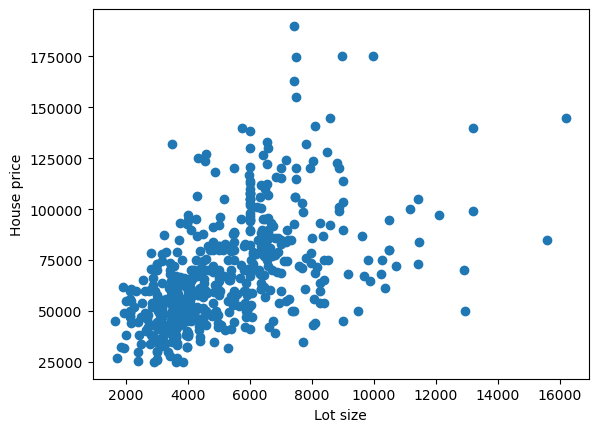

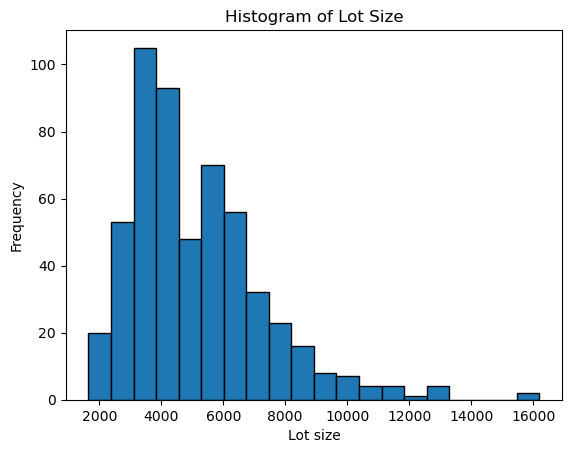

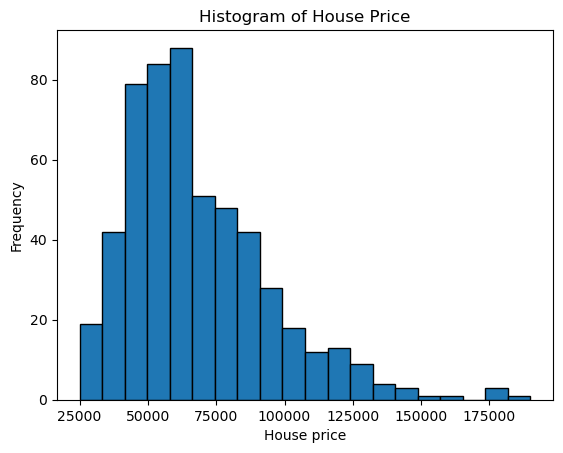

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Load the dataset
filename = "./data/simple_windsor.csv"
names = ["lotsize", "price"]
dataset = np.loadtxt(filename, delimiter=',').astype(np.int64)

X_full, y_full = dataset.T

plt.scatter(X_full, y_full)
plt.xlabel('Lot size')
plt.ylabel('House price')

# Plot histogram of the feature (lot size)
plt.figure()
plt.hist(X_full, bins=20, edgecolor='black')
plt.xlabel('Lot size')
plt.ylabel('Frequency')
plt.title('Histogram of Lot Size')
plt.show()

# Plot histogram of the label (house price)
plt.figure()
plt.hist(y_full, bins=20, edgecolor='black')
plt.xlabel('House price')
plt.ylabel('Frequency')
plt.title('Histogram of House Price')
plt.show()




---
**Task 1 (easy): Questions💡**
1. In the cell below list and characterize 5 observations about the data.


---

## 1 - Data exploration

**Linear regression assumptions:**
1. Linearity: The data is linear, when lot size increase so does house prices.
2. Independence: There is only a single feature, thus there is no dependence between other features.
3. Normality: They are not completely non-normally distributed. They are slightly leaning to the left, but do look normally distributed.
4. Homoscedasticity: There should be a constant variance in differences between features and labels. We would argue this assumption holds, as the data variance is even, except for some outliers (such as a huge factory with a high lot size, might not cost a lot, because the big room is unhabitable, and doesn't have an expensive kitchen so to say.)

**Characteristics**

There seems to be a postive correlation between the data. But a calculation of pearson r, would help confirm this idea. As well as calculating the p-value, to see if the correlation is statistically significant.

There also seems to be a clustering, around the lower range, meaning a lot of data points are from smaller and cheaper houses.

There are some outliers, such as a house with high lot size, but low price and vice versa.


### Splitting into train and test data
The following cell splits the dataset into $80\%$ training data and $20\%$ test data using the scikit-learn library
:


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

## Polynomial regression
The following exercise guides you through the steps (1-4) for learning the polynomial model.
1. Define the model, e.g. line or polynomial.
2. Identitfy knowns and uknowns.
3. Construct the design matrix $A$ for the dataset (see the `get_design_matrix`
 function below).
4. Estimate the model parameters using linear least squares ( [Task 2](#estimate) ).

The function `get_design_matrix`
 (defined in the cell below) creates a design matrix for a polynomial of order $N$.


In [6]:
def get_design_matrix(x, order=1):
    """
    Get the coefficients of polynomial in a least square sense of order N.
    
    :param x: Must be numpy array of size (N).
    :order n: Order of Polynomial.
    """
    
    if order < 1 or x.ndim != 1:
        return x

    count = x.shape[0]
    matrix = np.ones((count, order + 1), np.float64)

    for i in range(1, order+1):
        matrix[:, i] = x**i

    return matrix


---
**Task 2 (medium): Estimate model parameters👩‍💻**
Implement the function `train(X, y, order)`
 in the cell below to learn the model parameters. Use `get_design_matrix(X, order)`
 to create the design matrix.

---

In [7]:
def train(X, y, order):
    """
    :param X: Input vector.
    :param y: Training data values.
    :param order: Order of the model to estimate.
    
    :return: Parameters of model.
    """
    # Create the design matrix for the given polynomial order
    x_design = get_design_matrix(X, order)
    
    # Using linear squares on our knowns (input:x and labels:y), to get our unknowns (weights:w)
    w = np.linalg.inv(x_design.T @ x_design) @ x_design.T @ y
    return w


---
**Task 3 (easy): Define prediction model👩‍💻**
Use the learned model parameters to predict house prices given an input vector $X$ of lot sizes. Implement the prediction function `predict(X, params)`
 in the cell below. 

---

In [8]:
def predict(X, w):
    """
    :param X: Input vector.
    :param w: Estimated parameters.
    
    :return: Predicted y-values.
    """
    #Good ol' affine transformation of: Aw = y
    #A: design matrix, made from our inputs x
    #w: weights learned from least squares
    #y: our predictions
    X_design = get_design_matrix(X, len(w) - 1)
    return (X_design @ w).ravel()
    


---
**Task 4 (easy): Prediction👩‍💻**
In this task you will use the learnt model parameters for making predictions of house prices given lot sizes. Implement the following steps (marked by `#`
) in the code cell below.
1. Learn model parameters using `X_train`
 and `y_train`
. 
2. In the cell below calculate the predicted house prices (`y`
-values) given the lot-sizes defined in the `values`
 variable.
3. Plot the predicted house prices as a line-plot.


---

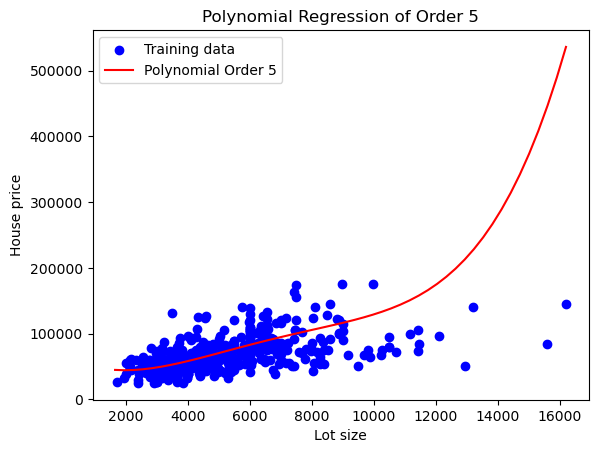

In [19]:
# (1) Learn model parameters with a polynomial of order 2 (for example)
order = 5
w = train(X_train, y_train, order)

# (2) Evaluate model
x_values = np.linspace(X_full.min(), X_full.max(), 50)
predicted_y_values = predict(x_values, w)

# (3) Plot predicted values

#Dette er vores punkter med x og y værdier.
plt.scatter(X_train, y_train, color='blue', label='Training data')
#Dette er vores x_values og deres tilhørende y_prediction
plt.plot(x_values, predicted_y_values, color='red', label=f'Polynomial Order {order}')
plt.xlabel('Lot size')
plt.ylabel('House price')
plt.title(f'Polynomial Regression of Order {order}')
plt.legend()
plt.show()


---
**Task 5 (medium): Order of Polynomial👩‍💻**
In this task you will experiment with the order of the polynomial model to investigate performance.
1. Increase the order of the polynomial and evaluate the results for:    1. A $3$rd-order polynomial.
    2. A $4$th-order polynomial.
    3. A $7$th-order polynomial.
    4. An $11$th-order polynomial.



Observe that the predictions deviate drastically from the actual lot sizes for the $7$th-order polynomial and above. 
1. Explain why this happens? 


---This problem can be solved by normalizing the input vectors. Normalization transforms the input values to the interval $[0, 1]$ by scaling and translating the inputs using the minimum and maximum values.
The cell below provides functions for normalizing and denormalizing (the inverse transformation) input vectors:


## Task 5 - Evaluation of model complexity

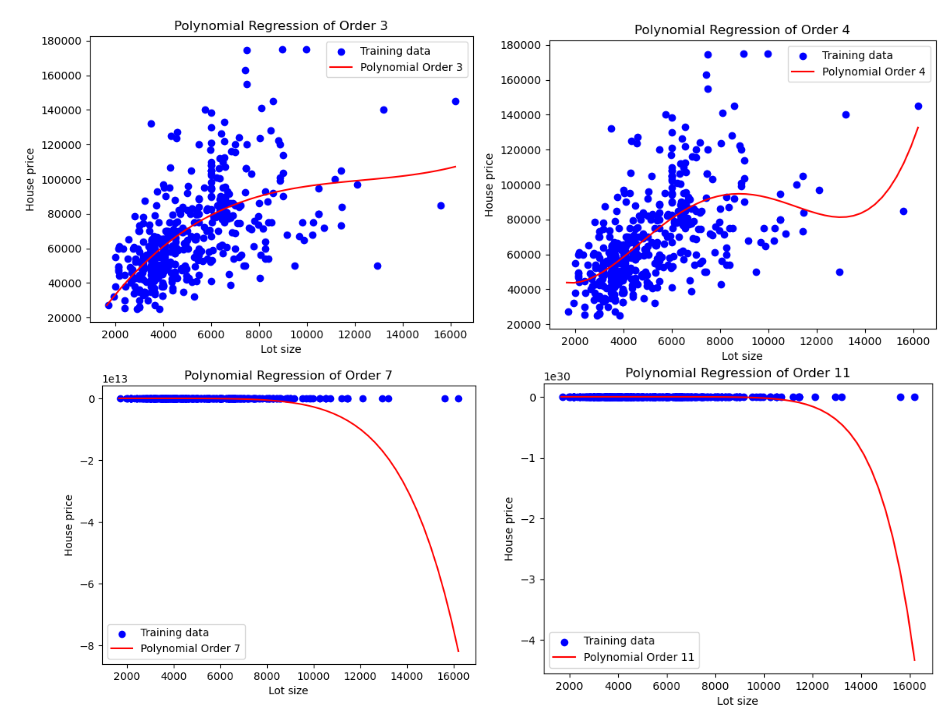

**Why does predictions suck at 7th order and higher:**

A higher order polynomial, might attempt to severely overfit the data, such as valuing an outlier a lot, because outliers are squared, and thus contribute enormously to the summarized squared error, which we are trying to minimize.


In [10]:
def normalized(X):
    n = (X - np.min(X_full))/np.max(X_full)
    return n

def denormalized(X):
    return X*np.max(X_full) + np.min(X_full)


---
**Task 6 (medium):  Higher order polynomials with normalization👩‍💻**
In this task you will redo [Task 4](#learn) using normalization. Write your solution in the cell below.
1. Normalize the inputs in the variable `X_{train}`
 using the function`normalized`
. 
2. Re-train the model parameters using the normalized inputs using $3$rd, $4$th, and $7$th order polynomials as in [Task 4](#learn).
3. Predict the values of (normalized) `X_{test}`
.
4. Plot the predicted result as a curve using `plt.plot`



---

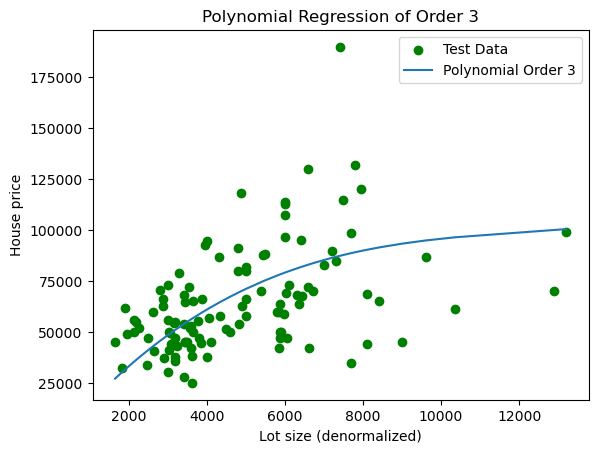

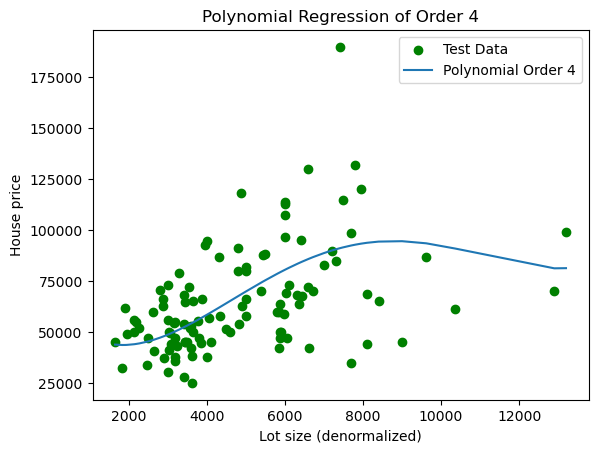

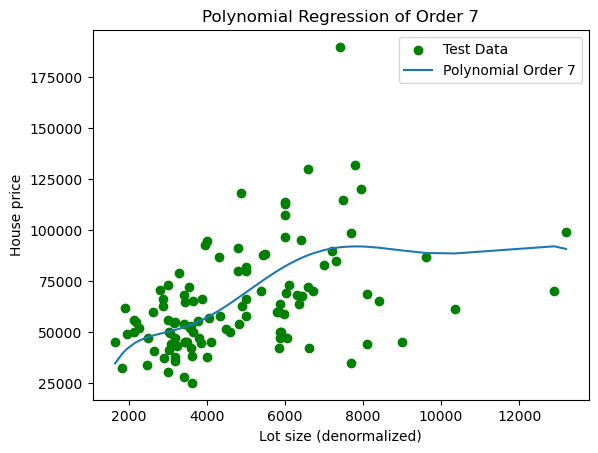

In [20]:
# (1) Normalize the inputs
X_train_normalized = normalized(X_train)
X_test_normalized = normalized(X_test)

orders = [3, 4, 7]
for order in orders:
    w = train(X_train_normalized, y_train, order)
    
    # Predicting y-values
    y_predicted = predict(X_test_normalized, w)

    #Smooth plot
    sorted_indices = np.argsort(X_test_normalized)
    X_test_sorted_normalized = X_test_normalized[sorted_indices]
    y_predicted_sorted = y_predicted[sorted_indices]

    # Denormalize X_test for plotting using your denormalization function
    X_test_sorted_denormalized = denormalized(X_test_sorted_normalized)

    #Plot
    plt.scatter(X_test, y_test, c="g", label='Test Data')
    plt.plot(X_test_sorted_denormalized, y_predicted_sorted, label=f"Polynomial Order {order}")
    plt.xlabel('Lot size (denormalized)')
    plt.ylabel('House price')
    plt.title(f'Polynomial Regression of Order {order}')
    plt.legend()
    plt.show()



---
**Task 7 (medium): Normalization improvement💡**
1. Visually inspect and reason about how normalization impacts the results.
2. Explain why normalization achieves a better performance.


---

## 7 Normalization improvement

Normalization makes polynomial terms behave more predictably because the input values are smaller and closer together. Without normalization, large input values can cause polynomial terms like 7th or 11th order to grow extremely large, which can lead to overfitting.

In other words:
Without normalization, the curve might oscillate wildly or create large, extreme curves.
With normalization, the curve will be more stable and follow the trend of the data better, as smaller input values reduce the risk of large polynomial terms skewing the model.

This would also help the problem, that we currently don't have, but if we had multiple parameters, that had wildly different ranges, we would ensure that with normalization that the parameters contribute equally.

In some cases it also helps with overflow, as values might be so large, that they require more memory, such as a long vs integer.
Less memory, is faster to calculate with, as we can fit more calculations when doing SIMD

## Evaluation
In the following steps you will evaluate the models using the _root mean squarred error_ (RMSE) on unseen data (test data). 
The _root mean squared error_ is defined as:

$$
 \sqrt{\frac{1}{m}\sum_{i=1}^{m}(f_{\mathbf{w}}(x_{i})-y_{i})^2}
$$

and calculates the average error measured in the same units as the house prices. 
The code cell below provides an implementation of the RMSE:


In [12]:
def rmse(X, y, w):
    X = normalized(X)
    ym = predict(X, w)
    return np.sqrt(np.mean((y-ym)**2))


---
**Task 8 (easy): Model evaluation👩‍💻**
In this task you will implement the function `evaluate_models`
 to evaluate polynomial models of order 1 to 19 using the _root mean squared error_. 
For each model order:
1. Learn the model parameters using the `train`
 function.
2. Calculate the _root mean squared error_ of the model on the training set.
3. Calculate the _root mean squared error_ of the model on the test set.


---

In [13]:
def evaluate_models():
    """Calculates the RMS error for both training and test data for models with polynomial orders from 1 to 19."""
    losses_train = []
    losses_test = []

    for order in range(1, 19):  # Polynomial degrees from 1 to 19
        # (1) Estimate parameters using the training data
        w = train(X_train_normalized, y_train, order)

        # (2) Calculate RMSE for training set - Kinda our BIAS
        rmse_train = rmse(X_train, y_train, w)

        # (3) Calculate RMSE for test set - Kinda our VARIANCE
        rmse_test = rmse(X_test, y_test, w)

        # Append results to lists
        losses_train.append(rmse_train)
        losses_test.append(rmse_test)

    return losses_train, losses_test



---
**Task 9 (easy): Plotting results👩‍💻**
1. Plot the training and test losses in the cell below. 
2. Explain why the test and training losses behave differently as the order of the polynomial increases.
3. Use RMSE and the plot(s) to argue what could be the consequences of using these models given that they have these properties. 


---

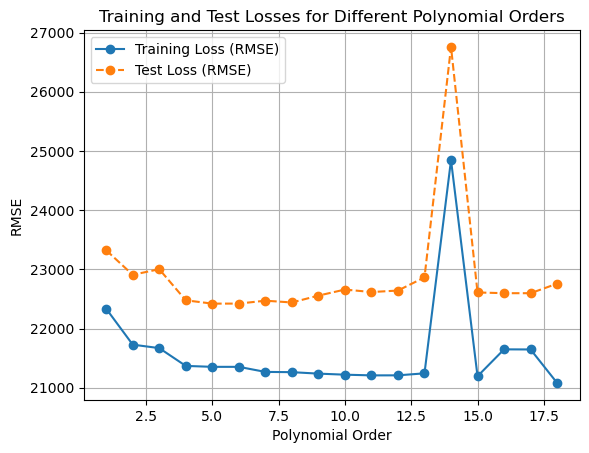

In [21]:
# Task 9.1: plotting
def plot_losses(losses_train, losses_test):
    orders = range(1, 19)
    
    plt.plot(orders, losses_train, label='Training Loss (RMSE)', marker='o')
    plt.plot(orders, losses_test, label='Test Loss (RMSE)', marker='o', linestyle='--')
    
    plt.xlabel('Polynomial Order')
    plt.ylabel('RMSE')
    plt.title('Training and Test Losses for Different Polynomial Orders')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming evaluate_models() returns the losses for both train and test
losses_train, losses_test = evaluate_models()

# Plot the losses
plot_losses(losses_train, losses_test)

## 9.2 and 9.3 - Evaluation

**9.2**

Increasing model complexity will often decreases bias, but increases variance.
This is because increasing the complexity, leads to overfitting, meaning that it will have a very RMSE on the training data.
But when attempting to use the overfitted model on unseen data, we will experience that it doesn't work as great (high RMSE / high variance)

**9.3**

If we are currently underfitting, it is better to increase model complexity.
Whereas if we are currently overfitting, it might be better to decrease model complexity.
We want to reach a "sweet-spot", where we have combined lowest bias and variance, meaning low error on training, and low error on our predictions compared to ground truth.



---
**Task 10 (medium): Reflection💡**
1. Reflect on whether it's possible and reasonable to chose a higher order polynomial for improving the training loss. Use the plot in your argumentation. 


---

# Task 10

To a certain point, yes.
But at some point, gaining lower training loss (bias), results in a very high increase in test error (variance).
We want to reach some sweet-spot.
